### Spotify user Reviews

In this notebook we are going to create a models for comparisons using `CNN` to classify spotify user reviews based on the public dataset.

We are going to use our custom dataset that we will load from my google drive. The dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset).

### Installing Helper Packages

In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 6.2 MB/s eta 0:00:00


https://github.com/pytorch/text


Next we are going to install torchtext with the version of pytorch that matches it's requirements.

In [2]:
!pip install torch==2.3.0  torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/

### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [3]:
import json
import time
import torch
import os
import random
import torchtext
import spacy
import re
import en_core_web_sm
import kagglehub

from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_wordcloud, plot_classification_report
from helperfns.utils import hms_string
from helperfns.text import clean_sentence
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords
from PIL import Image

import pandas as pd
import numpy as np
import torch.nn.functional as F

import warnings
import nltk
nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

torch.__version__, torchtext.__version__

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

('2.3.0+cu121', '0.18.0+cpu')

### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 19
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

The dataset that we are going to use was founc on kaggle:

https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset


The dataset that we will be using will contain `positive` and `negative` reviews from sportify users.

In [6]:
# with open('kaggle.json', 'r') as reader:
#   keys = json.loads(reader.read())
#   os.environ['KAGGLE_USERNAME'] = keys['username']
#   os.environ['KAGGLE_KEY'] = keys['key']

In [7]:
save_path_path = kagglehub.dataset_download("alexandrakim2201/spotify-dataset")
dataset_path = os.path.join(save_path_path, 'DATASET.csv')

100%|██████████| 2.90M/2.90M [00:00<00:00, 53.9MB/s]

Extracting files...


Let's read our dataset into a pandas dataframe and we are going to rename the column `Review` to `text`.

In [8]:
dataframe = pd.read_csv(dataset_path).rename(columns={
    'Review': 'text'
})
dataframe.text = dataframe.text.astype(str)
dataframe.label = dataframe.label.apply(lambda x: x.lower())
dataframe.head(2)

,text,label
0,"Great music service, the audio is high quality...",positive
1,Please ignore previous negative rating. This a...,positive


First let's count how many examples of reviews that are positive and how many of them belongs to the negative class.

In [9]:
dataframe.label.value_counts()

,count
label,
negative,29423
positive,23279


We can see that we have unbalanced reviews between positive and negative. Next let's check if we have `null` or `na` values in our dataset.

In [10]:
dataframe.isna().any()

,0
text,False
label,False


Next we will balance our dataset based on the class that has the least label count.

In [11]:
# Separate the majority and minority classes
majority_class = dataframe[dataframe['label'] == dataframe['label'].value_counts().idxmax()]
minority_class = dataframe[dataframe['label'] == dataframe['label'].value_counts().idxmin()]

# Downsample majority class to the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # without replacement
    n_samples=len(minority_class),  # match minority class size
    random_state=SEED  # for reproducibility
)


# Combine downsampled majority and original minority
balanced_df = pd.concat([majority_downsampled, minority_class]).reset_index(drop=True)

balanced_df.tail(3)

,text,label
46555,I tried to open the app and it wont open I res...,positive
46556,Good,positive
46557,Nice app to play music and at very affordable ...,positive


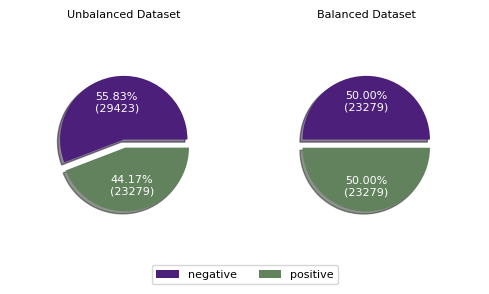

In [12]:
unbalanced_label_counts = dataframe.label.value_counts()
balanced_label_counts = balanced_df.label.value_counts()

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Colors for the pie chart segments
colors = ['#4C1F7A', '#62825D']

# Plot the first pie chart
axes[0].pie(unbalanced_label_counts, labels=unbalanced_label_counts.index,
            autopct=lambda x: fmt(x, len(dataframe)), shadow=True,
            explode=[0, .09],
            textprops={'color': 'white', 'fontsize':8}, radius=0.7, colors=colors)
axes[0].set_title("Unbalanced Dataset", fontsize=8, color='k')

# Plot the second pie chart
axes[1].pie(balanced_label_counts, labels=balanced_label_counts.index,
            autopct=lambda x: fmt(x, len(balanced_df)), shadow=True,
            explode=[0, .09],
            textprops={'color': 'white', 'fontsize':8}, radius=0.7, colors=colors)
axes[1].set_title("Balanced Dataset", fontsize=8, color='k')

# Add a single legend for both charts
fig.legend(balanced_label_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)

# Adjust layout and remove axis for a cleaner look
plt.tight_layout()
plt.show()

### Data Splitting
We are going to generate 4 sets from our dataset. Which are:

1. `training`
2. `testing`
3. `validation`
4. `inference`

We are going to take ``20%`` of the training data and use it as the test dataset. For the remaining `80%` of the training dataset we are going to take the validation set. And in the `test` set we will deduct the `inference` set which will be `5%` of the `testing` data.

> The `inference` data will be used for model inference at a later stage after model evaluations are completed.

In [13]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=SEED)
test_df, inference = train_test_split(test_df, test_size=0.1, random_state=SEED)

### Data Analyisis

First we are going to have a look at how the labels are distributed in the `training`, `validation`, `inference` and `testing` subsets.

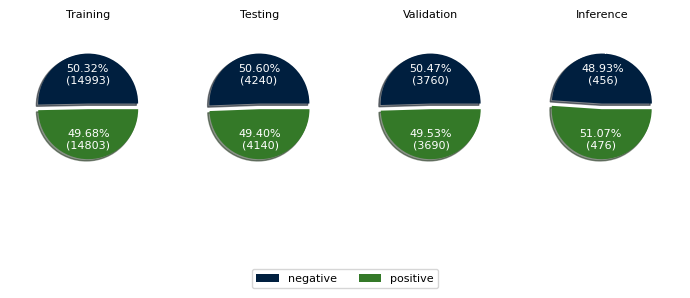

In [14]:
train_dist_label	= {i:0 for i in train_df.label.unique()}
for val in train_df.label:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test_df.label.unique()}
for val in test_df.label:
  test_dist_label[val] += 1

val_dist_label	= {i:0 for i in valid_df.label.unique()}
for val in valid_df.label:
  val_dist_label[val] += 1

inference_dist_label	= {i:0 for i in inference.label.unique()}
for val in inference.label:
  inference_dist_label[val] += 1


colors = ['#001F3F', '#347928']
fig, axes = plt.subplots(1, 4, figsize=(7, 4))

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct=lambda x: fmt(x, len(train_df)),
            textprops={'color': 'white', 'fontsize':8}, radius=.8, explode=[.0, .09],
            colors=colors, shadow=True,
            )
axes[0].set_title("Training", fontsize=8, color='k')

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct=lambda x: fmt(x, len(test_df)),
            textprops={'color': 'white', 'fontsize':8}, radius=.8, explode=[0, .09],
            colors=colors, shadow=True,
            )
axes[1].set_title("Testing", fontsize=8, color='k')

axes[2].pie(val_dist_label.values(), labels=val_dist_label.keys(), autopct=lambda x: fmt(x, len(valid_df)),
            textprops={'color': 'white', 'fontsize':8}, radius=.8, explode=[0, .09],
            colors=colors, shadow=True,)
axes[2].set_title("Validation", fontsize=8, color='k')

axes[3].pie(inference_dist_label.values(), labels=inference_dist_label.keys(), autopct=lambda x: fmt(x, len(inference)),
            textprops={'color': 'white', 'fontsize':8}, radius=.8, explode=[0, .09],
            colors=colors, shadow=True,)
axes[3].set_title("Inference", fontsize=8, color='k')

fig.legend(list(val_dist_label.keys()), loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

Let's visualize the distribution of examples between sets, after we have balanced our dataset.

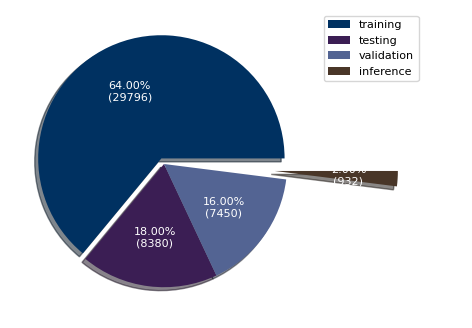

In [15]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(valid_df), len(inference)], labels=['training', 'testing', 'validation', 'inference'],
        autopct=lambda x: fmt(x, len(balanced_df)), textprops={'color': 'white', 'fontsize':8}, radius=1,
        colors=['#003161', '#3B1E54', '#536493', '#493628'],
        explode= [.05, 0, .0, 0.9],
        shadow=True,
        )
plt.legend(fontsize=8, labels=['training', 'testing', 'validation', 'inference'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [16]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(train_df):,}"],
    ["TESTING", f"{len(test_df):,}"],
    ["VALIDATION", f"{len(valid_df):,}"],
    ["INFERENCE", f"{len(inference):,}"],
    ["TOTAL", f"{len(test_df) + len(train_df) + len(valid_df) + len(inference):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+--------+
| Set        |  Total |
+------------+--------+
| TRAINING   | 29,796 |
| TESTING    |  8,380 |
| VALIDATION |  7,450 |
| INFERENCE  |    932 |
| TOTAL      | 46,558 |
+------------+--------+


Next we are going to visualize how frequently words appears in the each set among these sets:

1. training
2. testing
3. validation

In [17]:
train_text_counter = Counter()
for line in train_df.text:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_df.text:
    test_text_counter.update(line.lower().split())

valid_text_counter = Counter()
for line in valid_df.text:
    valid_text_counter.update(line.lower().split())

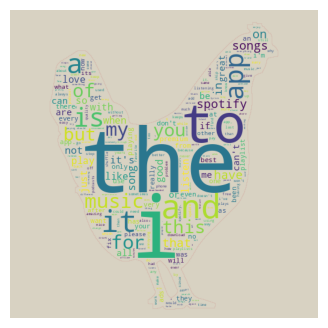

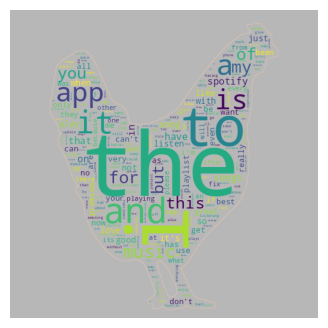

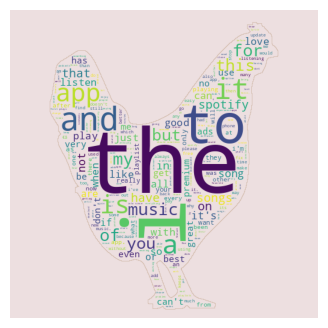

In [18]:
plot_wordcloud(train_text_counter,
               title="",
               mask="chicken",
               background_color="#D8D2C2",
               figsize=(4, 4),
               fontsize=10,
               save_path='training_1.png'
)
plot_wordcloud(
    test_text_counter, title="", mask="chicken", background_color="#B7B7B7", figsize=(4, 4),
               fontsize=10, save_path='testing_1.png'
)
plot_wordcloud(
    valid_text_counter, title="", mask="chicken", background_color="#EDDFE0", figsize=(4, 4),
    fontsize=10,
    save_path='validation_1.png'
)

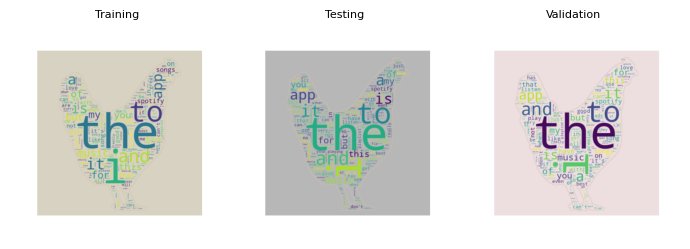

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

axes[0].imshow(Image.open('training_1.png'))
axes[0].axis('off')
axes[0].set_title("Training", fontsize=8, color='k')

axes[1].imshow(Image.open('testing_1.png'))
axes[1].axis('off')
axes[1].set_title("Testing", fontsize=8, color='k')

axes[2].imshow(Image.open('validation_1.png'))
axes[2].axis('off')
axes[2].set_title("Validation", fontsize=8, color='k')
plt.tight_layout()
plt.show()

We can see that most of the words that are commonly appearing in this copus are `"stopwords"`. We are going to remove these stopwords. In the following code cell we are going to remove stopwords from our dataframes and check the new word clouds.

In [20]:
eng_stopwords = stopwords.words('english')
def stopwords_remover(sent: str) -> str:
  words = sent.split(' ')
  return ' '.join([word for word in words if word not in eng_stopwords])

train_df.text = train_df.text.apply(stopwords_remover).apply(lambda x: None if len(x) == 0 else x)
test_df.text = test_df.text.apply(stopwords_remover).apply(lambda x: None if len(x) == 0 else x)
valid_df.text = valid_df.text.apply(stopwords_remover).apply(lambda x: None if len(x) == 0 else x)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
valid_df.dropna(inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [21]:
train_df.head(2)

,text,label
0,Good app,positive
1,"The app open anymore, stuck logo everytime I t...",negative


Next let's visulaize the wordclouds after removing stopwords.

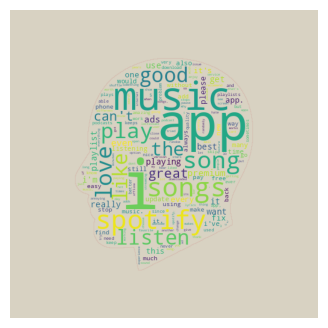

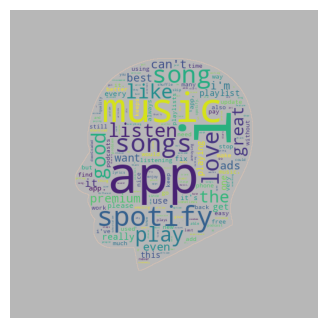

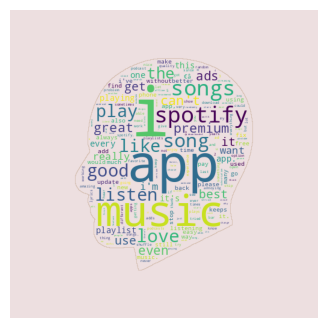

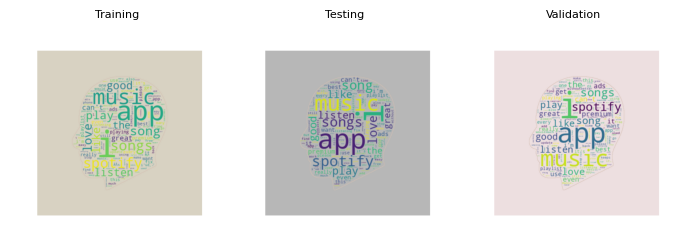

In [22]:
train_text_counter = Counter()
for line in train_df.text:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_df.text:
    test_text_counter.update(line.lower().split())

valid_text_counter = Counter()
for line in valid_df.text:
    valid_text_counter.update(line.lower().split())

plot_wordcloud(train_text_counter,
               title="",
               mask="head",
               background_color="#D8D2C2",
               figsize=(4, 4),
               fontsize=10,
               save_path='training_1.png'
)
plot_wordcloud(
    test_text_counter, title="", mask="head", background_color="#B7B7B7", figsize=(4, 4),
               fontsize=10, save_path='testing_1.png'
)
plot_wordcloud(
    valid_text_counter, title="", mask="head", background_color="#EDDFE0", figsize=(4, 4),
    fontsize=10,
    save_path='validation_1.png'
)

fig, axes = plt.subplots(1, 3, figsize=(7, 4))

axes[0].imshow(Image.open('training_1.png'))
axes[0].axis('off')
axes[0].set_title("Training", fontsize=8, color='k')

axes[1].imshow(Image.open('testing_1.png'))
axes[1].axis('off')
axes[1].set_title("Testing", fontsize=8, color='k')

axes[2].imshow(Image.open('validation_1.png'))
axes[2].axis('off')
axes[2].set_title("Validation", fontsize=8, color='k')
plt.tight_layout()
plt.show()

We can see from the word clouds that the most appearing word can actually prove that this is spotify a `music` application.



### Features and Labels
Our fetures are the actual ``text`` in the dataframes which is the column named ``text`` and our labels will come from the column called `labels`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [23]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values

# val
val_texts = valid_df.text.values
val_labels = valid_df.label.values

### Text Preprocessing

In our text processing pipeline we need to do the following steps:
1. `text_cleaning`
- First we are going to remove punctuation url's and numbers, from the text. For that we are going to use a function called `clean_sentence`  which cleans the text, by removing punctuations, numbers, tags, urls, etc from a sentence.


2. ``tokenize sentences``
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from ``spacy`` language model.

3. ``vocabulary``
* We will to create a vocabulary based on our sentences that are in the train dataset. A ``vocabulary`` is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the ``spacy-en`` language model. The reason we are using the english langauge model it's because our ``text`` are in ``english``.

In [24]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

['This', 'is', 'a', 'boy', '.']

In [25]:
def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    sent = re.sub(
        r"(@|#)([A-Za-z0-9]+)", " ", sent
    )
    sent = re.sub(
        r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent
    )
    sent = re.sub(r"https?\S+", " ", sent, flags=re.MULTILINE)  # removing url's
    sent = re.sub(r"\d", " ", sent)  # removing none word characters
    sent = re.sub(
        r"[^\w\s\']", " ", sent
    )
    sent = re.sub(r"\s+", " ", sent).strip()  # remove more than one space
    return sent


### Vocabulary
In the following code cell we are going to create a vocabulary object from ``torchtext``.  So we are going to use the ``Counter`` module from collections to generate these counts from our ``train`` text.

We are going to specify the ``min_freq`` to ``2`` meaning that the words that does not appear at least ``2`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [26]:
counter = Counter()
for line in train_texts:
  line = clean_sentence(line)
  tokens = tokenizer(line)
  counter.update(tokens)

In [27]:
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [28]:
stoi = vocabulary.get_stoi()
print("Vocab Size: ", len(stoi))

Vocab Size:  7514


### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).


> Note that our `text_pipeline` should also do the same process during vocabulary creation.

In [29]:
def text_pipeline(x: str):
  values = list()
  x = stopwords_remover(x)
  x = clean_sentence(x)
  tokens = tokenizer(x)
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a ``labels_vocab`` which is a label to integer representation.

In [30]:
labels_dict = {k: v for v, k in enumerate(train_df.label.unique())}
labels_dict

{'positive': 0, 'negative': 1}

The ``label_pipeline`` function will then takes in the label and then returns us an integer representation of that label.

In [31]:
label_pipeline = lambda x: labels_dict[x]

### Pre-trained word embeddings.

In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.50d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `50` dimension for each word.

In [32]:
EMBEDDING_DIM = 50
glove_vectors = vocab.GloVe(name='6B', dim=EMBEDDING_DIM)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:13<00:00, 30154.99it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [33]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `"him"`.

In [34]:
EMBEDDING_MATRIX[stoi['him']]

tensor([ 0.1196, -0.0454,  0.0511, -0.8287,  0.9766,  0.1113, -0.5459,  1.1561,
        -0.6808,  0.0602, -0.2876,  0.8806, -0.9179, -0.1833,  0.8418, -0.1186,
        -0.1496, -0.1616, -0.3741, -0.4534, -0.1852,  1.0392,  0.5567, -0.1431,
         0.7139, -2.9407, -0.0519, -0.1387,  0.3215, -0.9797,  2.9054,  0.5343,
        -0.8142, -0.4885,  0.0112,  0.4221,  0.3900,  0.4524, -0.0071, -0.6489,
         0.0911,  0.4689, -0.5819,  0.4565,  0.0273, -0.4454, -0.4237, -0.6279,
         0.0246, -0.1434])

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `SpotifyUserReviewsDataset`. This dataset will takes in the labels and the text of a set.

In [35]:
class SpotifyUserReviewsDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(SpotifyUserReviewsDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` and ``labels``. This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features`` and ``labels``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features and labels to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``labels`` and ``features``.

In [36]:
def tokenize_batch(batch, max_len=50, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch float tensors since it is a binary classification.
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list), features

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `AIHumanDataset` class.

In [37]:
train_dataset = SpotifyUserReviewsDataset(train_labels, train_texts)
test_dataset = SpotifyUserReviewsDataset(test_labels, test_texts)
val_dataset = SpotifyUserReviewsDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data`` for our ``3`` sets. We are going to use the ``batch_size`` of ``128`` and our ``collate_function`` is ``tokenize_batch``. For the validation and testing dataset we are going to set the ``shuffle`` to ``False`` because there's no need fo us to shuffle these examples.

In [38]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [39]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [40]:
lbl

tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 1.])

The first sentence in the batch.

In [41]:
txt[0]

tensor([ 362,  403,  512,  167,   49,  144,  233,  128,  644, 1002,  709, 1914,
          18,   19, 1471, 5526,  522,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=torch.int32)

### Models.

Next we are going to create 2 models which are:

1. `SpotifyUserReviewsCNN1DModel` - uses conv 1d layers to process sequential data.
2. `SpotifyUserReviewsCNN2DModel` -  uses conv 2d layers to process sequential data.


In [42]:
class SpotifyUserReviewsCNN1DModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
            dropout, pad_idx):
    super(SpotifyUserReviewsCNN1DModel, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv1d(
                in_channels = embedding_dim,
                out_channels = n_filters,
                kernel_size = fs
              ) for fs in filter_sizes
        ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_dim)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    embedded = self.embedding(text)
    embedded = embedded.permute(0, 2, 1)
    conved = [F.relu(conv(embedded)) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)

In [43]:
class SpotifyUserReviewsCNN2DModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, n_filters, filter_sizes, output_size,
            dropout, pad_idx):
    super(SpotifyUserReviewsCNN2DModel, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_size, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv2d(
                in_channels = 1,
                out_channels = n_filters,
                kernel_size = (fs, embedding_size)
            ) for fs in filter_sizes
       ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    embedded = self.embedding(text)
    embedded = embedded.unsqueeze(1)
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)




Next we are going to create 2 model instances based on the model that we have just created.

In [44]:
INPUT_DIM = len(stoi)
OUTPUT_DIM = len(labels_dict) if len(labels_dict) > 2 else 1
EMBEDDING_DIM = 50
N_FILTERS = 50
DROPOUT = 0.67789
PAD_IDX = stoi['[pad]']
N_FILTERS = 50
FILTER_SIZES = [3, 3, 5, 5, 7, 7]

cnn_2d_model = SpotifyUserReviewsCNN2DModel(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)
cnn_1d_model = SpotifyUserReviewsCNN1DModel(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)

cnn_2d_model

SpotifyUserReviewsCNN2DModel(
  (embedding): Sequential(
    (0): Embedding(7514, 50, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0-1): 2 x Conv2d(1, 50, kernel_size=(3, 50), stride=(1, 1))
      (2-3): 2 x Conv2d(1, 50, kernel_size=(5, 50), stride=(1, 1))
      (4-5): 2 x Conv2d(1, 50, kernel_size=(7, 50), stride=(1, 1))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.67789, inplace=False)
)

In [45]:
cnn_1d_model

SpotifyUserReviewsCNN1DModel(
  (embedding): Sequential(
    (0): Embedding(7514, 50, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0-1): 2 x Conv1d(50, 50, kernel_size=(3,), stride=(1,))
      (2-3): 2 x Conv1d(50, 50, kernel_size=(5,), stride=(1,))
      (4-5): 2 x Conv1d(50, 50, kernel_size=(7,), stride=(1,))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.67789, inplace=False)
)

### Model Parameters

In the following code cell we are going to count parameters of each model achitecture and visualize it using a table.

In [46]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["cnn_2d", *count_trainable_params(cnn_2d_model)],
    ["cnn_1d", *count_trainable_params(cnn_1d_model)]
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| cnn_2d |      451,301 |          451,301 |
| cnn_1d |      451,301 |          451,301 |
+--------+--------------+------------------+


Initializing the model weights.

In [47]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [48]:
cnn_1d_model.apply(initialize_weights)
cnn_2d_model.apply(initialize_weights)

SpotifyUserReviewsCNN2DModel(
  (embedding): Sequential(
    (0): Embedding(7514, 50, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0-1): 2 x Conv2d(1, 50, kernel_size=(3, 50), stride=(1, 1))
      (2-3): 2 x Conv2d(1, 50, kernel_size=(5, 50), stride=(1, 1))
      (4-5): 2 x Conv2d(1, 50, kernel_size=(7, 50), stride=(1, 1))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=300, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.67789, inplace=False)
)

### Loading Embedding Vectors
In the following code cells we are going to load the pretained custom vectors in our embedding layer to our models. We are going to load the embedding vectors tha suits our data using the ``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

In [49]:
cnn_1d_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)
cnn_2d_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2243,  1.1986,  0.6373,  ..., -0.2753, -0.9041,  0.3269],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Optimizer and Criterion
In the following code cell we are going to define the ``optimizers``
 for all the 2 models and a single criterion. For the ``optimizer`` we are going to use the ``Adam`` optimizer with default parameters and for the criterion we are going to use the ``BCEWithLogitsLoss()`` function since this is a binary classification.

In [50]:
cnn_1d_optimizer = torch.optim.Adam(cnn_1d_model.parameters())
cnn_2d_optimizer = torch.optim.Adam(cnn_2d_model.parameters())

criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our ``binary_accuracy`` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [51]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Training and evaluation functions.

In the following code cell we are going to create our ``train`` and ``evalute`` functions:

In [52]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    predictions = model(X).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      predictions = model(X).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


### Training Loop.

When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [53]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, ett:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(ett)

### Training Models

The folloing code cell will run a training loop for the model for `10` epochs.

In [54]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETT"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [55]:
EPOCHS = 10

cnn_1d_history, cnn_1d_ett, cnn_1d_last_saved_epoch = run_train_loop(
    cnn_1d_model, 'cnn_1d.pt', train_loader, val_loader, EPOCHS,
    optimizer=cnn_1d_optimizer, criterion=criterion
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.573 |    0.756 | 0:00:11.21 |
| Validation | 0.345 |    0.853 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.357 |    0.848 | 0:00:09.54 |
| Validation | 0.311 |    0.871 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.315 |    0.873 | 0:00:16.85 |
| Validation | 0.296 |    0.879 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 saving best model...
+------------+----

In [56]:
cnn_2d_history, cnn_2d_ett, cnn_2d_last_saved_epoch = run_train_loop(
    cnn_2d_model, 'cnn_2d.pt', train_loader, val_loader, EPOCHS,
    optimizer=cnn_2d_optimizer, criterion=criterion
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.423 |    0.808 | 0:00:24.07 |
| Validation | 0.309 |    0.870 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.313 |    0.872 | 0:00:23.91 |
| Validation | 0.290 |    0.879 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.282 |    0.886 | 0:00:25.06 |
| Validation | 0.281 |    0.886 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 saving best model...
+------------+----

Next we are going to check the the last saved epoch and the total training time the ``CNN`` models took.

In [57]:
rows = [
      ["cnn_1d", f'{EPOCHS}', f'{cnn_1d_last_saved_epoch}', f'{hms_string(cnn_1d_ett)}'],
      ["cnn_2d", f'{EPOCHS}', f'{cnn_2d_last_saved_epoch}', f'{hms_string(cnn_2d_ett)}']
]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")

CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+--------+--------------+------------------+-------------------------+
| MODEL  | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+--------+--------------+------------------+-------------------------+
| cnn_1d |           10 |                7 |              0:01:41.89 |
| cnn_2d |           10 |                4 |              0:04:11.73 |
+--------+--------------+------------------+-------------------------+


### Training History

In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

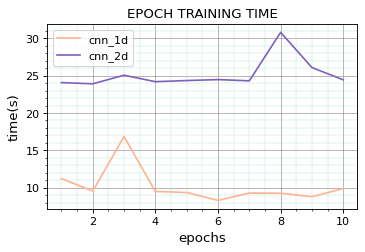

In [59]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, cnn_1d_history.epoch_train_time, color='#FFB38E', label='cnn_1d')
plt.plot(epochs, cnn_2d_history.epoch_train_time, color='#7E60BF', label='cnn_2d')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for each model that was observed during model training.

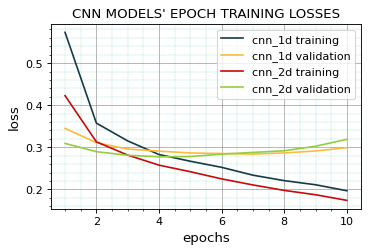

In [60]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, cnn_1d_history.train_losses, color='#173B45', label='cnn_1d training')
plt.plot(epochs, cnn_1d_history.val_losses, color='#FABC3F', label='cnn_1d validation')
plt.plot(epochs, cnn_2d_history.train_losses, color='#C40C0C', label='cnn_2d training')
plt.plot(epochs, cnn_2d_history.val_losses, color='#95CD41', label='cnn_2d validation')

plt.title("CNN MODELS' EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation accuracies using a line graph for each model that was observed during model training.

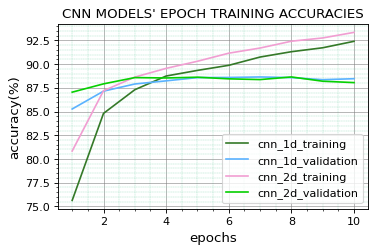

In [63]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in cnn_1d_history.train_acc], color='#347928', label='cnn_1d_training')
plt.plot(epochs, [acc * 100 for acc in cnn_1d_history.val_acc], color='#5AB2FF', label='cnn_1d_validation')

plt.plot(epochs, [acc * 100 for acc in cnn_2d_history.train_acc], color='#F19ED2', label='cnn_2d_training')
plt.plot(epochs, [acc * 100 for acc in cnn_2d_history.val_acc], color='#06D001', label='cnn_2d_validation')

plt.title("CNN MODELS' EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.

In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [64]:
cnn_1d_model.load_state_dict(torch.load('cnn_1d.pt'))
cnn_2d_model.load_state_dict(torch.load('cnn_2d.pt'))

cnn_1d_test_loss, cnn_1d_test_acc = evaluate(cnn_1d_model, test_loader, criterion)
cnn_2d_test_loss, cnn_2d_test_acc = evaluate(cnn_2d_model, test_loader, criterion)


rows = [
      ["cnn_1d", f'{cnn_1d_test_loss:.3f}', f'{cnn_1d_test_acc*100:.2f}'],
      ["cnn_2d", f'{cnn_2d_test_loss:.3f}', f'{cnn_2d_test_acc*100:.2f}'],

]
tabulate_data(['MODEL', 'TEST LOSS', "TEST ACCURACY (%)"],
              rows, "CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")



CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+--------+-----------+-------------------+
| MODEL  | TEST LOSS | TEST ACCURACY (%) |
+--------+-----------+-------------------+
| cnn_1d |     0.290 |             88.20 |
| cnn_2d |     0.286 |             88.41 |
+--------+-----------+-------------------+


Next we are going to make predictions based with our test dataset for using our model.

In [65]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      y_pred = model(X).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions

cnn_1d_y_true, cnn_1d_y_preds = get_predictions(cnn_1d_model, test_loader, device)
cnn_2d_y_true, cnn_2d_y_preds = get_predictions(cnn_2d_model, test_loader, device)

### Confusion matrix

In the following code cell we are going to plot the `Confusion Matrix` of our model.

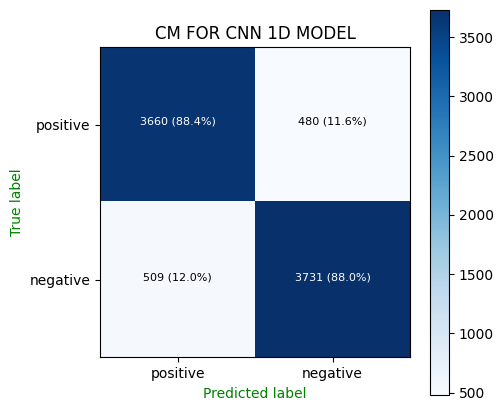

In [66]:
plot_complicated_confusion_matrix(cnn_1d_y_true, cnn_1d_y_preds,
  labels_dict.keys(), fontsize=8, figsize=(5, 5),
                                  title="CM FOR CNN 1D MODEL"
)

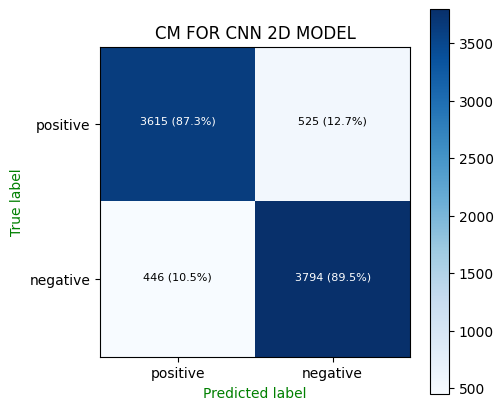

In [67]:
plot_complicated_confusion_matrix(cnn_2d_y_true, cnn_2d_y_preds,
  labels_dict.keys(), fontsize=8, figsize=(5, 5),
                                  title="CM FOR CNN 2D MODEL"
)

### Classification Report

Next we are going to plot the classification report of our model based on the test dataset.

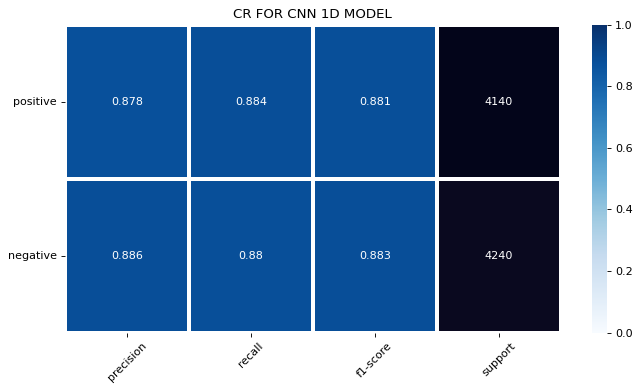

In [68]:
fig, ax = plot_classification_report(
    cnn_1d_y_true, cnn_1d_y_preds,
    title='CR FOR CNN 1D MODEL',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

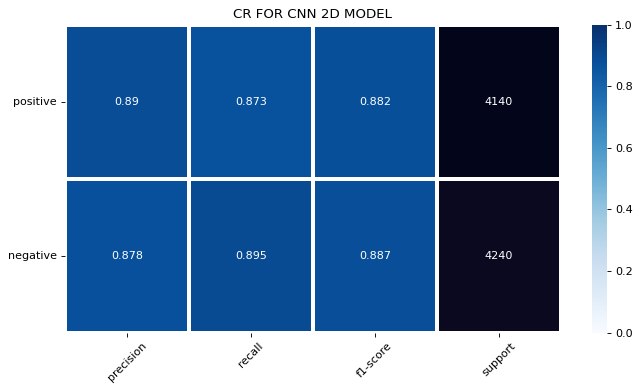

In [69]:
fig, ax = plot_classification_report(
    cnn_2d_y_true, cnn_2d_y_preds,
    title='CR FOR CNN 2D MODEL',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

### Model Inference

In this section we are going to test our modelnif it can make predictions based on the user input.

In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [70]:
def inference_preprocess_text(text, max_len=50, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [72]:
classes = list(labels_dict.keys())
def predict_sentiment(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      prob = torch.sigmoid(model(tensor).squeeze(0)).cpu().item()
      prediction = 1 if prob >= 0.5 else 0
      class_name = classes[prediction]
      confidence = prob if prediction == 1 else 1 - prob
      pred_data = [
          ["class_id",  prediction],
          ["class_name",  class_name],
          ["probability",  round(float(confidence), 3)],
      ]
      return dict(pred_data)

### Negative Review

In [73]:
pos_text = 'this app is good!'
neg_text = 'this app is bad!'

print("Positive: ", neg_text)
print("\n")
predict_sentiment(cnn_1d_model, neg_text, device=device)


Positive:  this app is bad!




{'class_id': 1, 'class_name': 'negative', 'probability': 0.649}

In [ ]:
predict_sentiment(cnn_2d_model, neg_text, device=device)

{'class_id': 0, 'class_name': 'not sexist', 'probability': 0.898}

### Positive Review

In [74]:
print("Positive Review: ", pos_text)
print("\n")
predict_sentiment(cnn_1d_model, pos_text, device=device)

Positive Review:  this app is good!




{'class_id': 0, 'class_name': 'positive', 'probability': 0.98}

In [75]:
predict_sentiment(cnn_2d_model, pos_text, device=device)

{'class_id': 0, 'class_name': 'positive', 'probability': 0.979}

Next we are going to predict using our `inference` data. Let's check how this dataframe looks:

In [78]:
inference.reset_index(inplace=True, drop=True)
inference.head(2)

,text,label
0,We love Spotify. We can find almost anything w...,positive
1,I really do enjoy the amount of music this app...,negative


Next thing we are going to create a function called `generate_predictions` that will return the dataframe of predictions.

In [85]:
def generate_predictions(dataframe):
  _data_values = []
  for text in dataframe.text.values:
    conv1d = predict_sentiment(cnn_1d_model, text, device=device)
    conv2d = predict_sentiment(cnn_2d_model, text, device=device)
    _data_values.append({
        'conv1d_pred': conv1d.get('class_name'),
        'conv1d_probability': conv1d.get('probability'),
        'conv2d_pred': conv2d.get('class_name'),
        'conv2d_probability': conv2d.get('probability')
    })
  return pd.DataFrame(_data_values)

pred_df = generate_predictions(inference)

In [87]:
pred_df.head(3)

,conv1d_pred,conv1d_probability,conv2d_pred,conv2d_probability
0,positive,0.852,positive,0.801
1,negative,0.988,negative,0.978
2,positive,0.932,positive,0.930


Then we are going to merge the dataframes aso that we can see how good each model was in predicting text from different class.

In [89]:
merged_df = pd.concat([inference, pred_df], axis=1)
merged_df.head(10)

,text,label,conv1d_pred,conv1d_probability,conv2d_pred,conv2d_probability
0,We love Spotify. We can find almost anything w...,positive,positive,0.852,positive,0.801
1,I really do enjoy the amount of music this app...,negative,negative,0.988,negative,0.978
2,"Very good music apps,even though I'm new to us...",positive,positive,0.932,positive,0.930
3,Why do I pay for premium if I don't even have ...,negative,negative,0.967,negative,0.968
4,"This app is useless, unless not being able to ...",negative,negative,0.975,negative,0.976
5,There's some issue in the new version I suppos...,negative,negative,0.999,negative,0.999
6,An amazing app but if you dont have a sort of ...,negative,positive,0.510,negative,0.627
7,It looks pretty but it won't let me do anythin...,negative,negative,0.934,negative,0.914
8,"This is a great music app, my only problem is ...",positive,negative,0.874,negative,0.886
9,Doing well,positive,positive,0.845,positive,0.867
